Goal: Fuse GPS and INS measurements together to give locational data. Compare the locational data off of sensor fusion with ground truth locational data. The data is extracted from Kaggle, The Zurich Urban Micro Aerial Vehicle Dataset. Details on the dataset can be found here: https://rpg.ifi.uzh.ch/docs/IJRR17_Majdik.pdf

Q: What's the typical altitude?
A: The document https://www.kaggle.com/datasets/mrisdal/zurich-urban-micro-aerial-vehicle says that all data is 10-15 meters above the ground. 

Q: What's the time format?
A: The first column for each dataset contains time data computed in microseconds. Divide by $10^{6}$ to get seconds. 

Q: The clocks are synced but they are not aligned, meaning the measurments are not taken at the same time or the same interval. 

Q: How long did the entire data recording last?
A: The time on the files suggest that the measurements were recorded between 7 to 2720 seconds. That is, for about 45 minutes. 

Dimensionality

Because the frequncy of the sensor measurement varies, the number of measurements taken per sensor is different. 
- GPS has 81169 entries, 
- Pose has 135098 entries,
- Raw Accel has 27050 enties,
- Raw Gyro has 27050 entries,
- Pressure has 27052 entries. 

Frequencies

- Pose data has frequency 50 Hz, or updates every 0.02 seconds.
- Accel, Gyro, Baro have frequency 10 Hz, or update every 0.1 second
- GPS has frequency 30 Hz, or updates every 0.03 seconds.

Glossary
- Micro aerial vehicle (MAV)

In order to extract accurate data from the INS sensors (raw -> calibrated), we need to know the calibration constants and biases. For now, it is not in our interest to get into all that, but it is useful to note a few facts before moving on. 
- zero-rate level is the output power when there is not angular velocity in the gyroscope

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing
GPSData = pd.read_csv('archive/OnboardGPS.csv')
PoseData = pd.read_csv('archive/OnboardPose.csv')
RawAccelData = pd.read_csv('archive/RawAccel.csv')
RawGyroData = pd.read_csv('archive/RawGyro.csv')
PressureData = pd.read_csv('archive/BarometricPressure.csv')
GroundTruth = pd.read_csv('archive/GroundTruthAGL.csv')

In [3]:
# basic info: number of non-null entries

GPSData.info(), print("--------------------------------"), PoseData.info(), 
print("--------------------------------"), RawAccelData.info(), print("--------------------------------"),
RawGyroData.info(), print("--------------------------------"),PressureData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81169 entries, 0 to 81168
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Timpstemp        81169 non-null  int64  
 1    imgid           81169 non-null  int64  
 2    lat             81169 non-null  float64
 3    lon             81169 non-null  float64
 4    alt             81169 non-null  float64
 5    s_variance_m_s  81169 non-null  float64
 6    c_variance_rad  81169 non-null  float64
 7    fix_type        81169 non-null  int64  
 8    eph_m           81169 non-null  float64
 9    epv_m           81169 non-null  float64
 10   vel_n_m_s       81169 non-null  float64
 11   vel_e_m_s       81169 non-null  float64
 12   vel_d_m_s       81169 non-null  float64
 13   num_sat         81169 non-null  int64  
 14  Unnamed: 14      0 non-null      float64
 15  Unnamed: 15      0 non-null      float64
 16  Unnamed: 16      0 non-null      float64
 17  Unnamed: 17 

(None, None, None)

In [33]:
# data cleaning

GPSData = GPSData.drop(['Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17'], axis=1)
# these columns were either empty or were all NaN's

# check for missing data
PressureData.isna().sum()

In [70]:
GPSData['Timpstemp'][5]

7175794

In [64]:
RawAccelData

,Timpstemp,Error_count,x,y,z,temperature,range_rad_s,scaling,x_raw,y_raw,z_raw,temperature_raw,
0,7090906,0,0.244930,0.193673,-10.587221,9.648201,156.906403,0.004788,-20,-80,-2195,-9152,
1,7190913,0,0.191809,-0.487059,-9.608912,9.648201,156.906403,0.004788,107,-31,-1980,-9152,
2,7290907,0,0.004109,-0.240623,-8.075992,9.645430,156.906403,0.004788,-142,-86,-1600,-9153,
3,7391908,0,-0.854582,-0.515484,-8.208664,9.648201,156.906403,0.004788,-139,-146,-1726,-9152,
4,7490907,0,-0.537616,0.054402,-9.014673,9.637119,156.906403,0.004788,-40,-10,-1969,-9156,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27045,2720394656,0,1.276790,-0.740558,-8.558648,5.407204,156.906403,0.004788,602,-607,-3136,-10683,
27046,2720494656,0,0.783740,-0.220319,-9.117740,5.373962,156.906403,0.004788,-118,445,-3053,-10695,
27047,2720594656,0,0.474089,-0.581616,-9.386983,5.398893,156.906403,0.004788,-680,202,-3451,-10686,
27048,2720694659,0,1.021824,-0.577675,-8.429438,5.390583,156.906403,0.004788,201,-504,-3401,-10689,


In [71]:
RawGyroData

,Timpstemp,Error_count,x,y,z,temperature,range_rad_s,scaling,x_raw,y_raw,z_raw,temperature_raw,
0,7089907,0,-0.259554,0.567248,0.153042,9.642660,34.906586,0.001064,-189,522,129,-9154,
1,7190913,0,0.090053,-0.297565,-0.252444,9.648201,34.906586,0.001064,68,-324,-237,-9152,
2,7289907,0,0.048989,-0.344591,-0.001826,9.648201,34.906586,0.001064,40,-339,20,-9152,
3,7390907,0,-0.096871,-0.037510,0.204749,9.656511,34.906586,0.001064,-75,-19,186,-9149,
4,7489907,0,-0.197409,0.219465,-0.098364,9.639891,34.906586,0.001064,-159,252,-110,-9155,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27045,2720389656,0,-0.064925,-0.048057,0.078764,5.385042,34.906586,0.001064,-28,-257,111,-10691,
27046,2720488657,0,-0.176746,-0.137372,0.089927,5.387812,34.906586,0.001064,-179,267,54,-10690,
27047,2720589656,0,0.145365,-0.034380,0.102123,5.398893,34.906586,0.001064,223,-16,19,-10686,
27048,2720689659,0,0.120776,-0.000128,0.078162,5.401663,34.906586,0.001064,431,99,46,-10685,


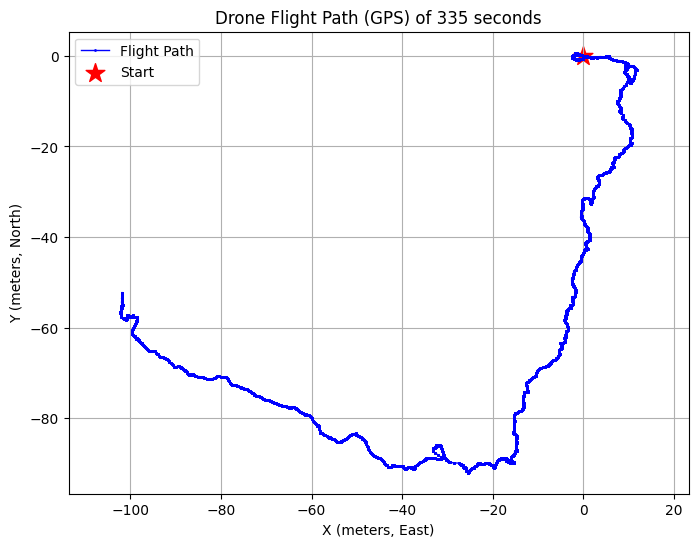

In [29]:
#  Create a GPS flight path of the drone

## convert ECEF (Earth centered, Earth fixed) to ENU (East, North, Up)

R = 6371000 # Earth's radius in meters
init_lat = GPSData[' lat'][0]
init_lon = GPSData[' lon'][0]
GPSData[' x_coord'] = (GPSData[' lon'] - init_lon) * (np.cos(init_lat)) * (np.pi/180) * R
GPSData[' y_coord'] = (GPSData[' lat'] - init_lat) * (np.pi/180) * R

# We'll just use the (x,y) cooridinates for now, to plot on the graph

plt.figure(figsize=(8,6))
plt.plot(
    GPSData[' x_coord'][0:10000], GPSData[' y_coord'][0:10000],
    marker='o',       # circle marker
    markersize=1,     # make marker smaller
    linestyle='-',    # solid line
    linewidth=1,      # make line thinner
    color='b',
    label='Flight Path'
)
plt.scatter(GPSData[' x_coord'][0], GPSData[' y_coord'][0], s=200, color='red', marker='*', label='Start')
plt.xlabel("X (meters, East)")
plt.ylabel("Y (meters, North)")
# 7009129, 341701724 microseconds
plt.title("Drone Flight Path (GPS) of 335 seconds")
plt.legend()
plt.axis('equal')  # equal aspect ratio so trajectory isn’t distorted
plt.grid(True)
plt.show()

## GPS Spoofing

The goal is to see the effect on pose following the introduction of polluted GPS data. Advanced spoofing techniques like spoof and drift is meant to give the autopilot false impressions of drift. The autopilot then makes corrections to remain on course. This results in false correction and instills false beliefs: autopilot thinks it's on course, in reality the drone drifts off course. We have the following steps ahead of us: 

- Create a dataset from kalman filter (w/o airdrag) fusing (true) GPS, Accelerometer, Gyro, barometer together: call it `planned_course`
    - Create a general kalman filter*
    - Derive the State matrix and set the parameters
- Pollute GPS Data to simulate spoofing in a dataset, call it `spoofed_gps`
- Fuse `spoofed_gps`, Accelerometer, Gyro, barometer together using the same Kalman filter, call it: `spoofed_course'
- Compare the (x,y) coordinates of `planned_course` and `spoofed_course'



In [ ]:
# a class to generate state vector of the drone

class INS:
    
    def __init__(self, dT = 1, x_acc = 0, y_acc = 0, 
                 z_acc = 0,
                 g     = 9.8, 
                 roll  = 0,
                 pitch = 0,
                 yaw   = 0,
                 p     = 0,
                 q     = 0,
                 r     = 0):
        
        '''
         dT    = sampling rate, 
         x_acc = acceleration, x-axis, 
         y_acc = acceleration, y-axis, 
         z_acc = acceleration, z-axis,
         g     = gravitational acceleration, 
         roll  = 0,
         pitch = 0,
         yaw   = 0,
         p     = angular velcity about x-axis, body frame
         q     = angular velcity about y-axis, body frame,
         r     = angular velcity about z-axis, body frame
        '''
        
                 self.dT    = dT
                 self.x_acc = x_acc
                 self.y_acc = 0
                 z_acc = 0
                 g     = 9.8
                 roll  = 0
                 pitch = 0
                 yaw   = 0
                 p     = 0
                 q     = 0
                 r     = 0

            
    def roll(self):
        
        # roll_angle = arctan(y_acc/x_acc)
        
        self.roll = np.arctan(self.y_acc, self.x_acc)
        
        return self.roll
    
    def update(self):
        

In [242]:
# uncomment to see the entire dataset and not just a snippet. delete None and change set to reset to undo
# pd.set_option('display.max_rows', None)

Text(0, 0.5, 'm/s^2')

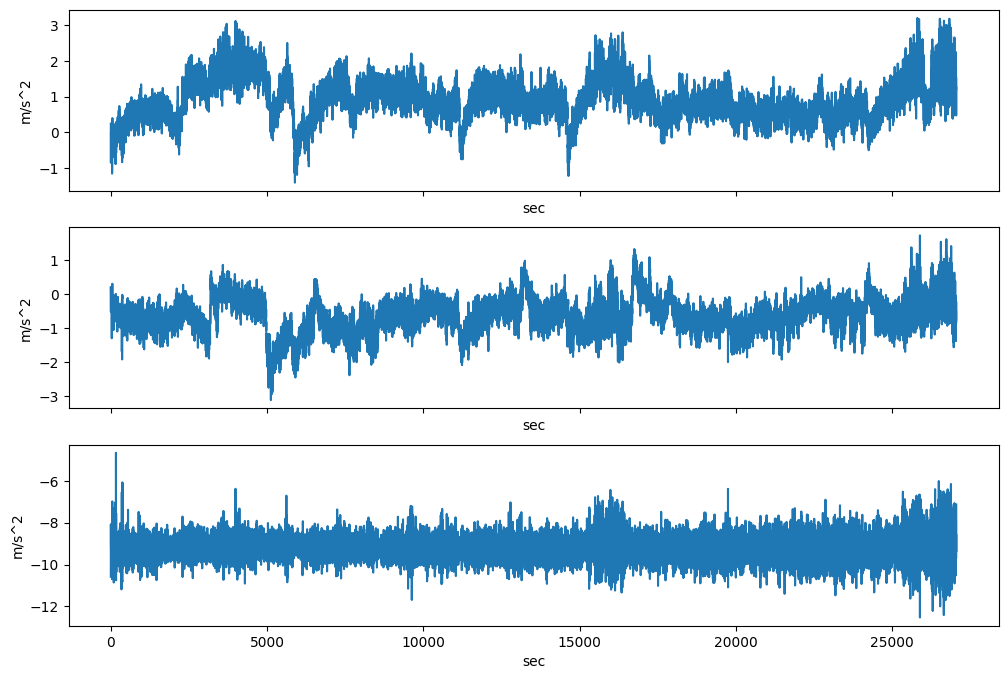

In [158]:
# visualizing adjusted/calibrated accelaration on x,y,z axes

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

seconds = np.arange(27050)
axs[0].plot(seconds, RawAccelData[' x'])
axs[0].set_xlabel('sec')
axs[0].set_ylabel('m/s^2')
axs[1].plot(seconds, RawAccelData[' y'])
axs[1].set_xlabel('sec')
axs[1].set_ylabel('m/s^2')
axs[2].plot(seconds, RawAccelData[' z'])
axs[2].set_xlabel('sec')
axs[2].set_ylabel('m/s^2')

# Note that z accel is around -9.8, which gives me reason to believe that (1) the MAV is hovering at a fixed 
# altitide, (2) the units are m/s^2, (3) the reference frame is the (.,.,-) quadrant.


Text(0, 0.5, 'rad/s')

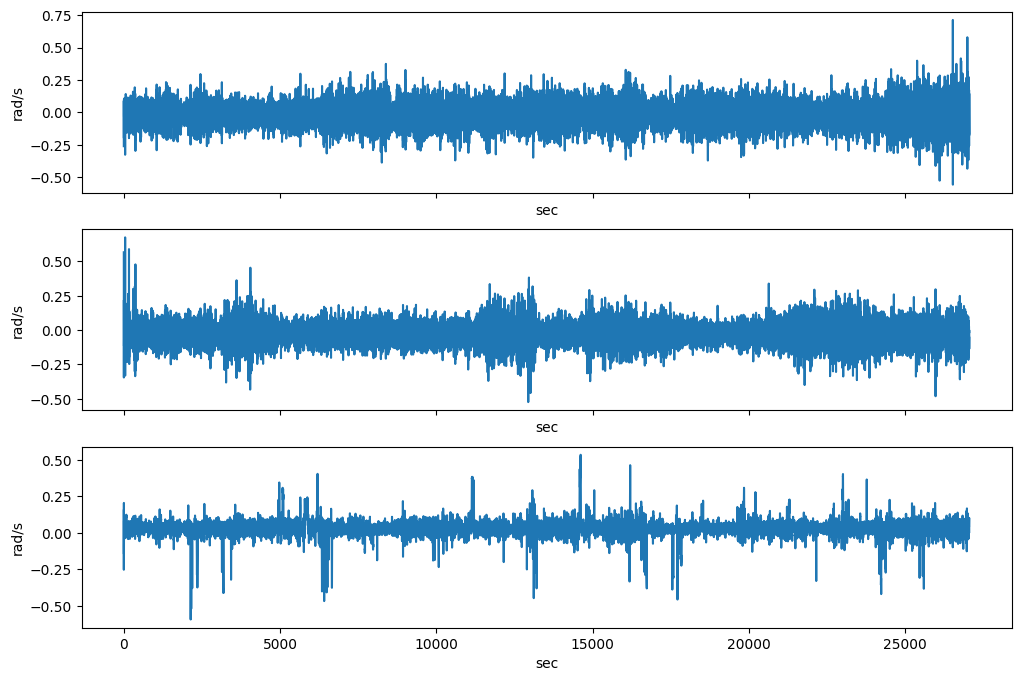

In [155]:
# visualizing calibrated the gyroscope measurements of angular velocity in x, y, and z axes respectively

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

seconds = np.arange(27050)
axs[0].plot(seconds, RawGyroData[' x'])
axs[0].set_xlabel('sec')
axs[0].set_ylabel('rad/s')
axs[1].plot(seconds, RawGyroData[' y'])
axs[1].set_xlabel('sec')
axs[1].set_ylabel('rad/s')
axs[2].plot(seconds, RawGyroData[' z'])
axs[2].set_xlabel('sec')
axs[2].set_ylabel('rad/s')

A discrepancy in our data is that altitude from GPS varies significantly from the altitude reported via the pressure sensor. This will be a great exercise. Fuse the measurements from GPS and Barometer to see if it matches the altitude from the ground truth. 

Text(0.5, 1.0, 'Ground Truth Altitude')

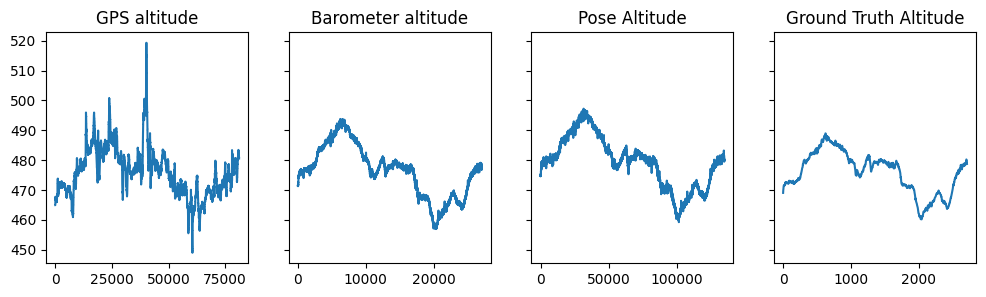

In [203]:
# GPS data

fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey = True)


seconds = np.arange(81169)
axs[0].plot(seconds, GPSData[' alt'])
axs[0].set_title(f'GPS altitude')


# # visualizing altitude data from pressure sensor 

Seconds = np.arange(27052)
axs[1].plot(Seconds, PressureData[' Altitude'])
axs[1].set_title(f'Barometer altitude')


# # altitude from Pose data 
# this comes from estimated pose from PIXHAWK autopilot http://pixhawk.org/modules/pixhawk

sEconds = np.arange(135098)
axs[2].plot(sEconds, PoseData[' Altitude'])
axs[2].set_title(f'Pose Altitude')

# # ground truth 


seconDs = np.arange(2708)
axs[3].plot(seconDs, GroundTruth[' z_gt'])
axs[3].set_title(f'Ground Truth Altitude')

We'll try a couple of different filters. We'll go from simplest to more sophisticated. First, let's start of with synchronous filters. Mean is the first one that comes to mind. 

In [225]:
# sycnronize the data 
## Aggregate higher frequency data from GPS: 30 Hz to lower frequency Barometer: 10 Hz.
### Take the average of every three data point on the GPS

GPSLocData = GPSData[['Timpstemp',' lat',' lon',' alt']]
GPSAggr = GPSLocData.groupby(GPSLocData.index // 3).mean().reset_index(drop=True).iloc[:-5]

# we dropped the last 7 rows to match the indexing of the barometer

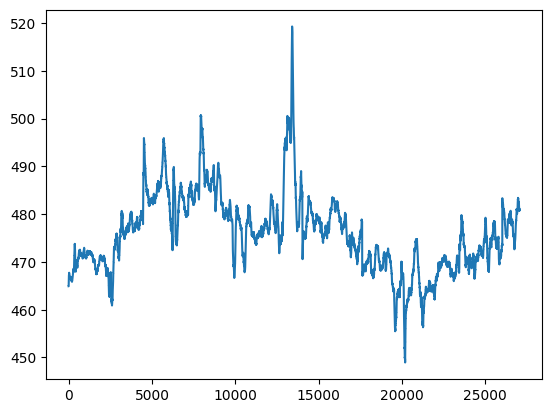

In [227]:
# plotting the aggregated data 

plt.plot(np.arange(27052), GPSAggr[' alt'])

Text(0.5, 1.0, 'Ground Truth Altitude')

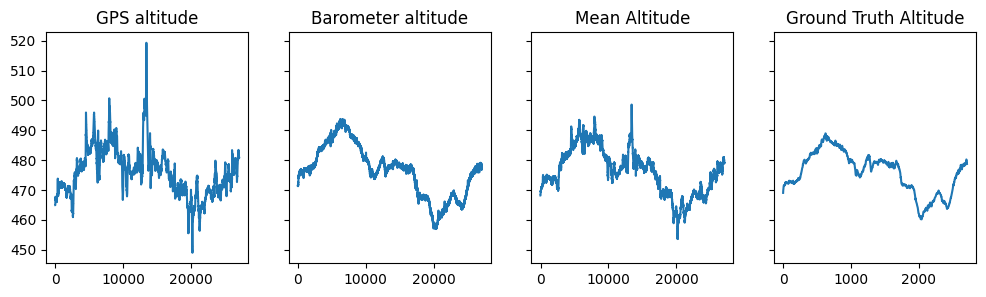

In [232]:
# merge GPSaggr and Barometer altitude into AltitudeAggr based on index

altitudeAggr = pd.concat([GPSAggr, PressureData[' Altitude']], axis=1)
# renaming the columns
altitudeAggr.columns = ['GPSTimeStamp', 'latitude', 'longitude', 'GPSAlt', 'BaroAlt']

altitudeAggr['meanAlt'] = altitudeAggr[['GPSAlt', 'BaroAlt']].mean(axis=1)

# GPS data

fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey = True)


seconds = np.arange(27052)
axs[0].plot(seconds, altitudeAggr['GPSAlt'])
axs[0].set_title(f'GPS altitude')


# # visualizing altitude data from pressure sensor 

Seconds = np.arange(27052)
axs[1].plot(Seconds, altitudeAggr['BaroAlt'])
axs[1].set_title(f'Barometer altitude')


# # altitude aggregated mean


sEconds = np.arange(27052)
axs[2].plot(sEconds, altitudeAggr['meanAlt'])
axs[2].set_title(f'Mean Altitude')

# # ground truth 


seconDs = np.arange(2708)
axs[3].plot(seconDs, GroundTruth[' z_gt'])
axs[3].set_title(f'Ground Truth Altitude')

Note that the mean altitude looks significantly better. We could consider weighted average of the barometer and the GPS altitude if we had access to the reliability data for each. It will be a fascinating investigation to uncover the weights for the means to perform weighted measurements. The weights will broadly be a function of the reliability of the observation for the given parameters. We won't worry about it now, but we hope to get back to it in future. 

We'll first perform simple exponential smoothing. The idea is to find an optimal parameter that minimizes MSE (mean squared error) between the 'smoothed' and original data. Here, we'll treat the mean altitude as the original data. 

In [271]:
npMeanAlt = altitudeAggr['meanAlt'].to_numpy()
def simpExpSmooth(orgAlt, e): # e is the exponential parameter
    SESAlt = np.array([orgAlt[0]])
    n = len(orgAlt)
    for i in range(1,n):
        SESAlt = np.append(SESAlt, e*orgAlt[i] + (1-e)*SESAlt[-1])
    diff = orgAlt - SESAlt
    MSE = np.mean(np.square(diff))
    return SESAlt, MSE

In [279]:
MSEs = []
for i in [.125, .25, .375, .5, .625, .75, .875, 1]:  
    SESAlt = simpExpSmooth(npMeanAlt, i)
    MSEs.append(SESAlt[1])
MSEs
    

[0.0714720788905792,
 0.021648427391695115,
 0.010030890752535361,
 0.00524907514549979,
 0.002687903294137046,
 0.0011605598127131444,
 0.00029482718490342184,
 0.0]

In [27]:
H = np.zeros((3, 16))
H[:, 3:6] = np.eye(3)
H

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

The MSE idea was naive because of course the MSE is lowest at $e = 1$. At any other $e$, the data has an add-on that increases the MSE. So, MSE is not the right measure of fit. I will come back to this analysis. For now, I want to focus on dead reackoning. It seems like the quaternion based system is quite popular too. 